*Sen2+1Cube*: Luke McQuade, June 2023 

# *dpolcat* Demo Notebook

This notebook introduces the *dpolcat* module - a tool for the automated categorization of dual-polarimetric Sentinel-1 radar imagery. It is inspired by Satellite Image Automatic Mapper (SIAM) and its concept of spectral categories [1].

The notebook is designed for use in the [Microsoft Planetary Computer](https://planetarycomputer.microsoft.com/) environment, and uses the [Sentinel-1 radiometrically-terrain-corrected (RTC) dataset](https://planetarycomputer.microsoft.com/dataset/sentinel-1-rtc) via STAC, as in [2].

## Setup

Adapted from [2].

In [1]:
import ipyleaflet
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pystac
import pystac_client
import planetary_computer
import requests
import rioxarray
import rich.table
import seaborn
import stackstac
import xarray

from IPython.display import Image

Automatically reload the module when changes are made.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import dpolcat as dp

### Helpers

In [4]:
from pyproj import Transformer

def bbox_to_lonlat(bbox, epsg):
    t = Transformer.from_crs(f"EPSG:{epsg}", "EPSG:4326")
    minY, minX = t.transform(bbox[0], bbox[1])
    maxY, maxX = t.transform(bbox[2], bbox[3])
    return [minX, minY, maxX, maxY]


def bbox_contains_bbox(bbox1, bbox2):
    """
    Tests whether bbox1 completely contains bbox2.
    Note. not valid for date-line crossing.
    """
    minx1, miny1, maxx1, maxy1 = bbox1
    minx2, miny2, maxx2, maxy2 = bbox2
    return minx1 <= minx2 <= maxx1 and miny1 <= miny2 <= maxy1

    
def summarize(item_collection, search_bbox_lonlat):
    """Summarize catalog search results"""
    table = rich.table.Table("id", "date", "A/D", "epsg", "bbox_lonlat", "bbox_enc", width=230)
    for item in item_collection:
        a_or_d = item.properties["sat:orbit_state"]
        item_epsg = item.properties["proj:epsg"]
        item_bbox = item.properties["proj:bbox"]
        item_bbox_lonlat = bbox_to_lonlat(epsg = item_epsg, bbox = item_bbox)
        bbox_enc = bbox_contains_bbox(item_bbox_lonlat, search_bbox_lonlat)
        table.add_row(item.id, item.properties["start_datetime"], a_or_d, str(item_epsg), str(item_bbox_lonlat), str(bbox_enc))
    return table


def get_item_by_id(item_collection, id: str):
    return [item for item in item_collection if item.id == id][0]


def db_scale(x):
    """Convert linear backscatter to dB"""
    return 10 * np.log10(x)


def cat_table(cat_result):
    """List the number of cells in each category."""
    table = rich.table.Table("Category", "Count", "%")
    total = cat_result.size
    for i in range(0, dp.NUM_CATEGORIES):
        c = int((cat_result == i).sum())
        pc = 100.0 * c / total 
        table.add_row(f"{i}", f"{c}", f"{pc:.3}")
    return table

def create_fcc(vv_sn, vh_sn):
    """Create a VV-VH false-colour composite for visualization."""
    
    composite = np.empty((vv_sn.shape[0], vv_sn.shape[1], 3))
    
    # The VH band tends to be lower on average than VV, so compensate by multiplying by 2.
    composite[..., 2] = vh_sn * 2                     # Blue
    composite[..., 1] = vv_sn                         # Green
    composite[..., 0] = (vv_sn + (vh_sn * 2)) / 2     # Red
    
    composite = np.clip(composite, 0, 1)
    
    data_vars = {
        'red': (['y', 'x'], composite[..., 0]),
        'green': (['y', 'x'], composite[..., 1]),
        'blue': (['y', 'x'], composite[..., 2])
    }

    composite = xarray.Dataset(
        data_vars=data_vars,
        coords={'x': vv_sn.coords['x'], 'y': vv_sn.coords['y']}
    )
    return composite

## Custom Scaling Function

Raw (linear) band data is typically very heavily positively skewed, which makes hierarchical thresholding (as in a decision tree) very sensitive. Power (dB) is often used as an alternative, but the numerical range can vary significantly between images, which also makes choosing thresholds difficult. So, a custom scaling function has been devised to try and mitigate these:

A shift-log-root scaling results in most values falling in the range 0 to 1, which is a little easier to work with. 

Note: taking the 4th root (rather than the 2nd root) results in more evenly distributed values, but adds significant bias in the low-end and is not that useful in practice.

### Demo

Load an image and compare the distributions of the different scaling techniques.

In [5]:
# Load image

# aoi = "tenerife"
aoi = "salzburg"

if aoi == "salzburg":
    epsg_num = 32633 # UTM zone 33N
    bbox = [13.02, 47.76, 13.09, 47.83]
    item_i = 1
    resolution = 10

elif aoi == "tenerife": 
    epsg_num = 32628 # UTM zone 28N
    bbox = [-16.96, 27.92, -16.05, 28.61]
    item_i = 2
    resolution = 10

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

search = catalog.search(
    collections=["sentinel-1-rtc"], bbox=bbox, datetime="2022-06-01/2022-06-15"
)
items = search.item_collection()
item = items[item_i]
print(f"Found {len(items)} items, selected {item.id}.")

ds = stackstac.stack(item, bounds_latlon=bbox, epsg=epsg_num, resolution=resolution)

vv_lin = ds.sel(band="vv")[0].compute()
vh_lin = ds.sel(band="vh")[0].compute()

Found 2 items, selected S1A_IW_GRDH_1SDV_20220604T165923_20220604T165948_043516_05321B_rtc.


/srv/conda/envs/notebook/lib/python3.11/site-packages/stackstac/prepare.py:363: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


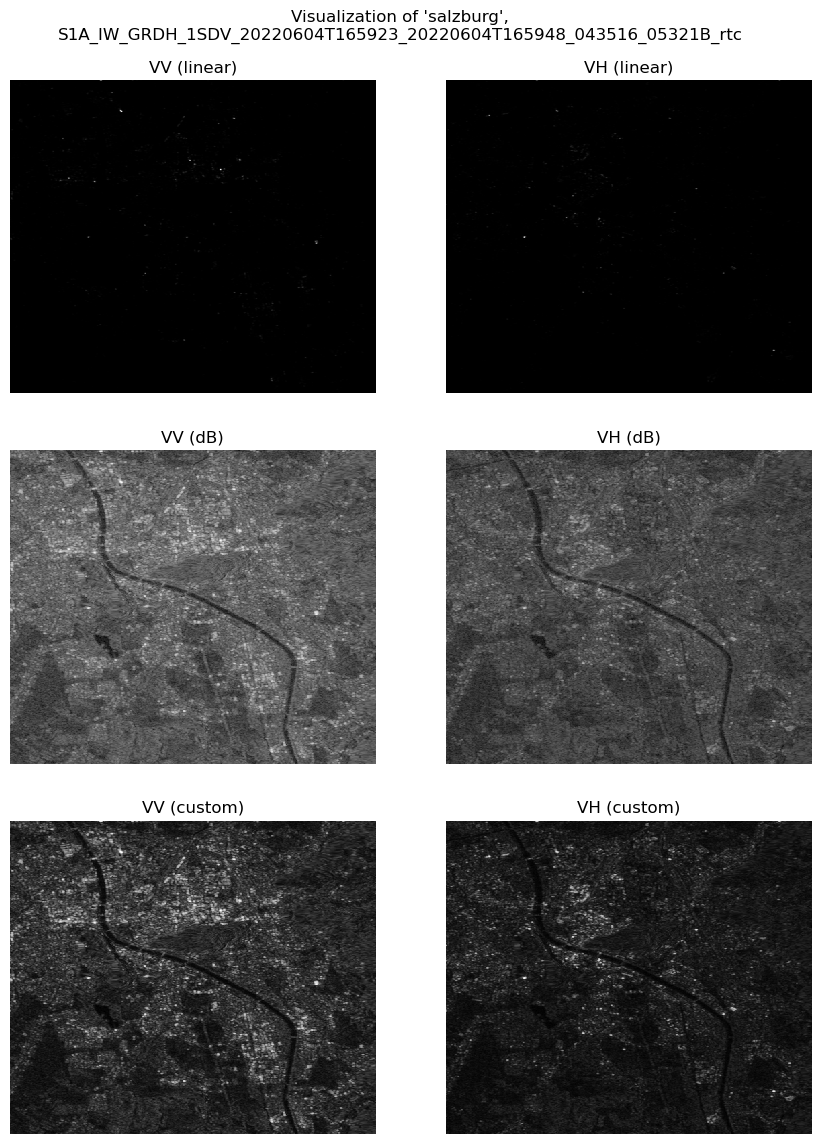

In [6]:
vv_db = db_scale(vv_lin)
vh_db = db_scale(vh_lin)

vv_sn = dp.scale_nice(vv_lin)
vh_sn = dp.scale_nice(vh_lin)

fig, axs = plt.subplots(3, 2, figsize=(9,12))
fig.suptitle(f"Visualization of '{aoi}',\n{item.id}")
plt.tight_layout(pad=2)
for (ax, (arr, title)) in zip(axs.flatten(),
    [
        [vv_lin, "VV (linear)"],
        [vh_lin, "VH (linear)"],
        [vv_db, "VV (dB)"],
        [vh_db, "VH (dB)"],
        [vv_sn, "VV (custom)"],
        [vh_sn, "VH (custom)"],
    ]):
    img = arr.plot.imshow(cmap="gray", add_colorbar=False, ax=ax)
    img.axes.set_axis_off()
    ax.set_title(title)

plt.show()

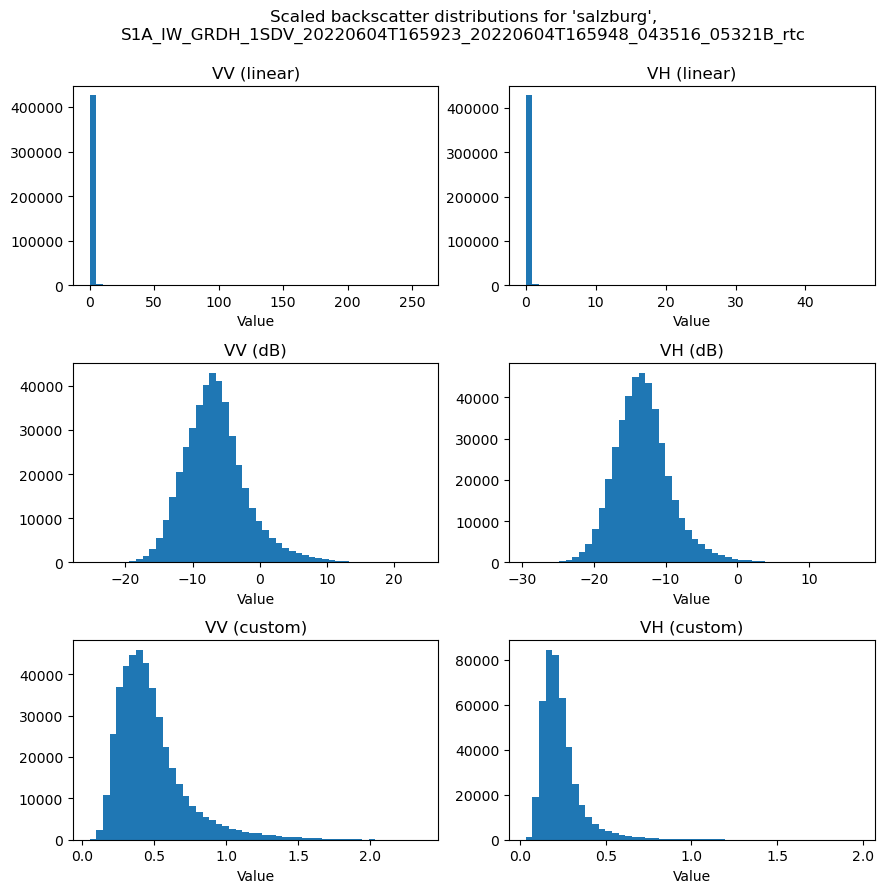

In [7]:
fig, axs = plt.subplots(3, 2, figsize=(9,9))
fig.suptitle(f"Scaled backscatter distributions for '{aoi}',\n{item.id}")
fig.tight_layout(pad=2, h_pad=3.5, w_pad=2)

vv_lin.plot.hist(bins=50, ax=axs[0,0])
axs[0,0].set_title("VV (linear)")
 
vh_lin.plot.hist(bins=50, ax=axs[0,1])
axs[0,1].set_title("VH (linear)")

vv_db.plot.hist(bins=50, ax=axs[1,0])
axs[1,0].set_title("VV (dB)")
 
vh_db.plot.hist(bins=50, ax=axs[1,1])
axs[1,1].set_title("VH (dB)")

vv_sn.plot.hist(bins=50, ax=axs[2,0])
axs[2,0].set_title("VV (custom)")

vh_sn.plot.hist(bins=50, ax=axs[2,1])
axs[2,1].set_title("VH (custom)")

for ax in axs.flatten():
    ax.set_xlabel("Value")

plt.show()

## Polarimetric Categorization

The main feature of dpolcat is to assign categories to combinations of VV and VH values. These categories are based on the physical scattering properties of surfaces and objects on the ground: specular, volume, double bounce, and combinations of these. This is achieved with a decision tree algorithm; see `dpolcat.categorize` for details of this.

The categories are visualized below for the typical range of (scaled) VV and VH values expected in an image.

A rough guide to the category numbers:
- Mostly surface scattering: 1,2,3,4
- Mostly volume scattering: 9,19,16,10
- Ill-defined (physically): 8
- NoData/invalid: 0
- Double-bounce/other: Remaining

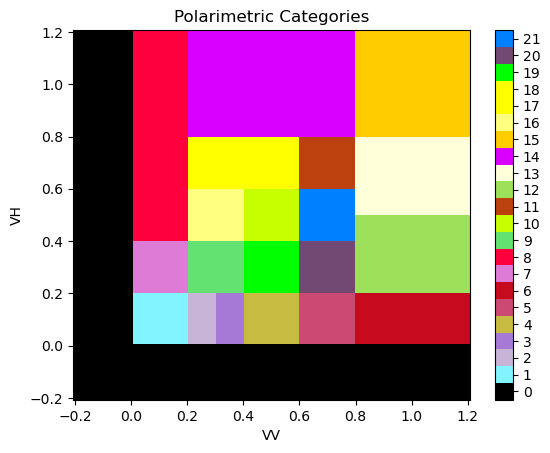

In [8]:
size = 100
steps = np.linspace(-0.2, 1.2, size)
colormap = mcolors.ListedColormap(dp.color_list / 255.0)
vv_ramp = np.vstack([steps] * size)
vh_ramp = vv_ramp.transpose()
test1 = xarray.DataArray(dp.categorize_np(vv_ramp, vh_ramp), coords=[steps, steps], dims=["VH", "VV"])
im = test1.plot(cmap=colormap, vmin=-0.5, vmax=dp.NUM_CATEGORIES - 0.5, add_colorbar=False)
cbar = plt.colorbar(im)
cbar.set_ticks(range(dp.NUM_CATEGORIES))
plt.title("Polarimetric Categories")
ax = plt.gca()
for el in [ax.xaxis.label, ax.yaxis.label,*ax.get_xticklabels(), *ax.get_yticklabels()]:
    el.set_fontsize(10)
plt.show()

### Demo

Below, we perform polarimetric categorization of the sample image we selected earlier.

In [9]:
cat_result = dp.categorize_xa(vv_sn, vh_sn)

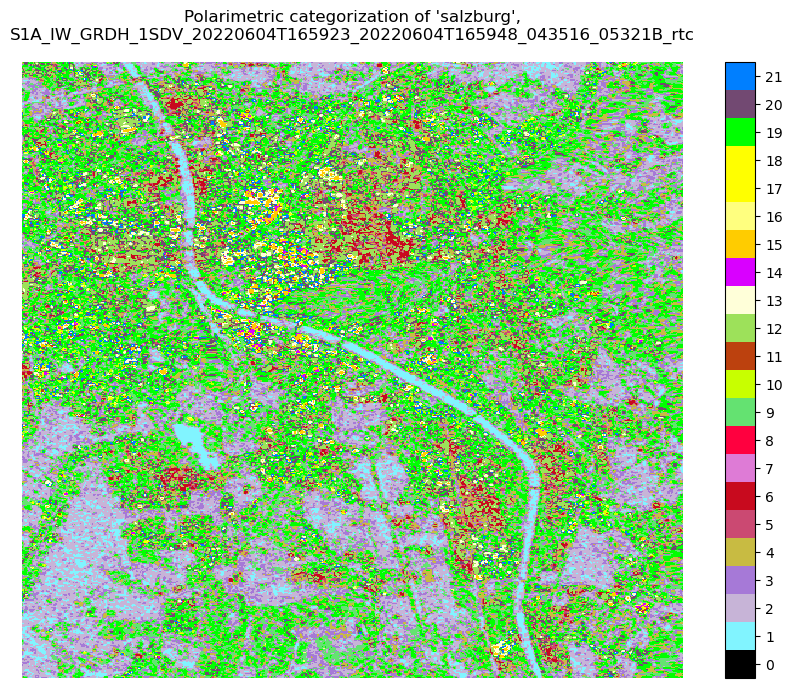

In [10]:
im = cat_result.plot(cmap=colormap, size=8, vmin=-0.5, vmax=dp.NUM_CATEGORIES-0.5, add_colorbar=False)
cbar = plt.colorbar(im)
cbar.set_ticks(range(dp.NUM_CATEGORIES))
plt.title(f"Polarimetric categorization of '{aoi}',\n{item.id}")
plt.axis("off")
plt.show()

The distribution of categories are as follows:

In [11]:
cat_table(cat_result)

┏━━━━━━━━━━┳━━━━━━━┳━━━━━━━━┓
┃ Category ┃ Count ┃ %      ┃
┡━━━━━━━━━━╇━━━━━━━╇━━━━━━━━┩
│ 0        │ 0     │ 0.0    │
│ 1        │ 16191 │ 3.75   │
│ 2        │ 62386 │ 14.5   │
│ 3        │ 54277 │ 12.6   │
│ 4        │ 43984 │ 10.2   │
│ 5        │ 9069  │ 2.1    │
│ 6        │ 6174  │ 1.43   │
│ 7        │ 438   │ 0.101  │
│ 8        │ 0     │ 0.0    │
│ 9        │ 51885 │ 12.0   │
│ 10       │ 7006  │ 1.62   │
│ 11       │ 1650  │ 0.382  │
│ 12       │ 24506 │ 5.68   │
│ 13       │ 6699  │ 1.55   │
│ 14       │ 700   │ 0.162  │
│ 15       │ 2684  │ 0.622  │
│ 16       │ 846   │ 0.196  │
│ 17       │ 64    │ 0.0148 │
│ 18       │ 710   │ 0.164  │
│ 19       │ 99384 │ 23.0   │
│ 20       │ 34377 │ 7.96   │
│ 21       │ 8610  │ 1.99   │
└──────────┴───────┴────────┘

### QGIS Colour Map

Create a QGIS Color Map file that can be used for dpolcat layer symbology.

In [12]:
lines = []

for i, c in enumerate(dp.color_list):
    label = i
    a = 255
    r, g, b = c
    lines.append(f"{i} {r} {g} {b} {a} {label}\n")

f = open("dpolcat-qgis-cmap.clr", "w")
f.writelines(lines)
f.close()

## Example: Flood Mapping

There was widespread flooding in Western Europe in the Summer of 2021. One of the affected areas was around the city of Duisburg in western Germany.

Let's develop a simple model to try and delineate the flooded area using polarimetric categories.

From inspection of images captured between the dates around the time of the flooding (2021-07-08 to 2021-07-21), the following images were selected for comparison:
* Pre-flood: S1A_IW_GRDH_1SDV_20210713T171647_20210713T171712_038762_0492ED_rtc
* Mid-flood: S1B_IW_GRDH_1SDV_20210716T054127_20210716T054152_027815_0351B0_rtc

In [13]:
# Larger region
# bbox = [6.638, 51.130, 7.731, 51.481]

# City
bbox = [6.695, 51.407, 6.847, 51.462]

search = catalog.search(
    collections=["sentinel-1-rtc"], bbox=bbox, datetime="2021-07-08/2021-07-21"
)
items = search.item_collection()
print(f"Found {len(items)} items")

epsg_num=32632
resolution=10

pre = get_item_by_id(items, "S1A_IW_GRDH_1SDV_20210713T171647_20210713T171712_038762_0492ED_rtc")
post = get_item_by_id(items, "S1B_IW_GRDH_1SDV_20210716T054127_20210716T054152_027815_0351B0_rtc")

Found 9 items


In [14]:
ds = stackstac.stack([pre, post], bounds_latlon=bbox, epsg=epsg_num, resolution=resolution)

vv_lin = ds.sel(band="vv").compute()
vh_lin = ds.sel(band="vh").compute()

vv_sn = dp.scale_nice(vv_lin)
vh_sn = dp.scale_nice(vh_lin)

cat_result = dp.categorize_xa(vv_sn, vh_sn)

/srv/conda/envs/notebook/lib/python3.11/site-packages/stackstac/prepare.py:363: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


Visualize the source and categorized images. The source images are visualized with a false-colour composite, in the manner:

* Red channel: average VV and VH
* Green channel: VV
* Blue channel: VH

Note: the VH band is typically lower than VV, so is amplified to compensate for this.

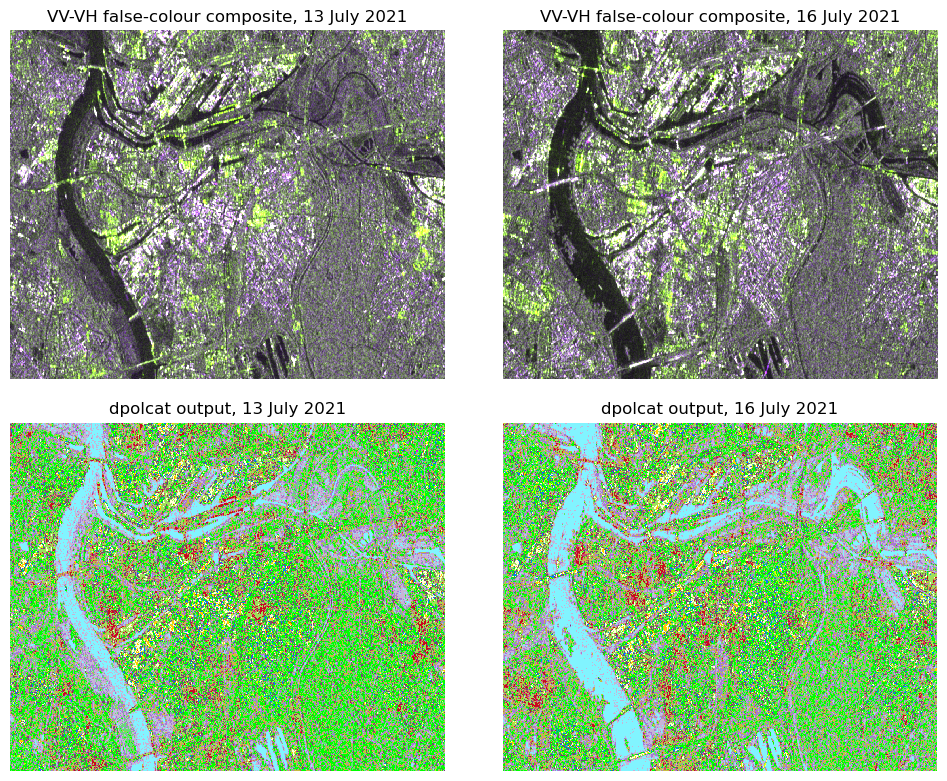

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(10,8))
# fig.suptitle(f"")
fig.tight_layout()
c_pre = create_fcc(vv_sn[0], vh_sn[0])
im1 = c_pre.to_array().plot.imshow(ax=axs[0,0])
axs[0,0].set_title("VV-VH false-colour composite, 13 July 2021")

c_post = create_fcc(vv_sn[1], vh_sn[1])
im2 = c_post.to_array().plot.imshow(ax=axs[0,1])
axs[0,1].set_title("VV-VH false-colour composite, 16 July 2021")

im3 = cat_result[0].plot(cmap=colormap, vmin=-0.5, vmax=dp.NUM_CATEGORIES-0.5, add_colorbar=False, ax=axs[1,0])
axs[1,0].set_title("dpolcat output, 13 July 2021")

im4 = cat_result[1].plot(cmap=colormap, vmin=-0.5, vmax=dp.NUM_CATEGORIES-0.5, add_colorbar=False, ax=axs[1,1])
axs[1,1].set_title("dpolcat output, 16 July 2021")

for ax in axs.flatten(): ax.set_axis_off()
plt.show()

Hopefully, you can make out the structures that make up the urban area of Duisburg, as well as the confluence of two rivers — the Rhine and the Ruhr.
Comparing the earlier and later categorized images, notice the widening of the cyan regions. These are areas of category 1, which correspond to low backscatter (both VV and VH), typical of calm water or very smooth surfaces. For our model, let's assume that cells that have newly changed to category 1 are flooded areas.

In [16]:
# Calculate new cat. 1 cells.
flooded = ((cat_result[1] == 1).astype(np.int8) - (cat_result[0] == 1).astype(np.int8)) == 1

Visualize the result.

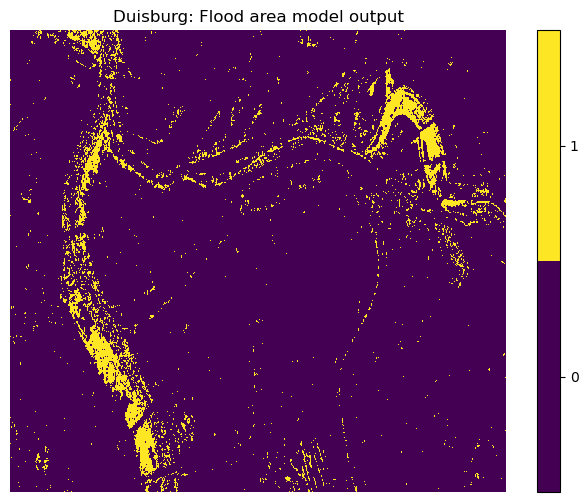

In [17]:
#colors = ["red", "blue"]
colors = ["#440154", "#FDE725"]
cmap = mcolors.ListedColormap(colors)

im = flooded.plot.imshow(size=6, add_colorbar=False, cmap=cmap, vmin=-0.5, vmax=1.5)
im.axes.set_axis_off()
im.axes.set_title("Duisburg: Flood area model output")
plt.colorbar(im, ticks=[0, 1])
plt.show()

You can see some solid regions of new cat. 1 cells near the rivers, which are likely flooded areas, but there are also many small, disparate areas. Radar data is notoriously highly variable, e.g., with [speckle](https://en.wikipedia.org/wiki/Speckle_(interference)), so let's apply some spatial filtering to reduce these effects.

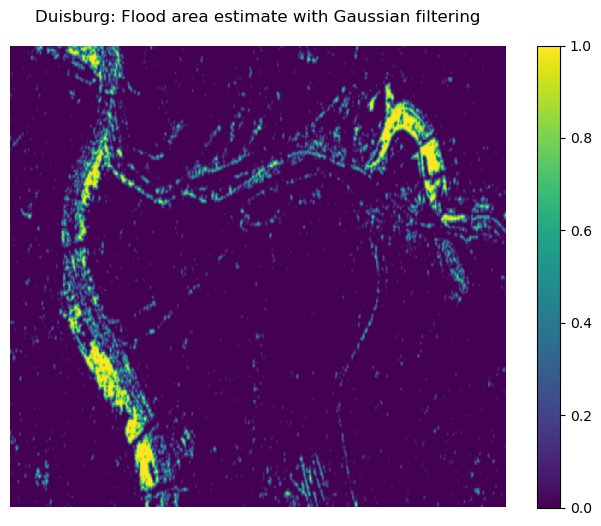

In [18]:
from scipy.ndimage import gaussian_filter

sigma = 1.5
flooded_gaussian = xarray.apply_ufunc(gaussian_filter, flooded.astype(np.float32), sigma)

im = flooded_gaussian.plot.imshow(size=6, add_colorbar=False)
plt.axis("off")
plt.colorbar(im)
plt.title("Duisburg: Flood area estimate with Gaussian filtering")
plt.show()

The filtering shows areas of high concentrations of estimated flood cells, versus low concentrations. Let's apply a threshold, keeping only the highly-concentrated areas.

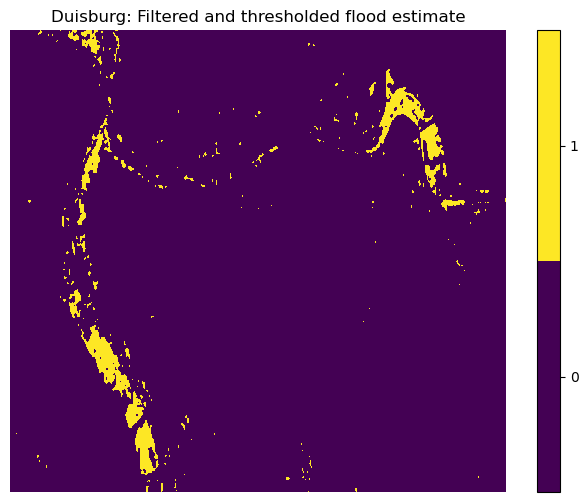

In [19]:
flooded_thres = flooded_gaussian > 0.6

im = flooded_thres.plot.imshow(size=6, add_colorbar=False, cmap=cmap, vmin=-0.5, vmax=1.5)
plt.axis("off")
plt.title("Duisburg: Filtered and thresholded flood estimate")
plt.colorbar(im, ticks=[0, 1])
plt.show()

This seems to have eliminated many of the disparate regions away from the rivers (likely false positives).

In [20]:
# Save the results
cat_result.rio.write_crs(epsg_num, inplace=True)
cat_result[0].astype(np.uint8).rio.to_raster("duisburg_pre_dpolcat.tif")
cat_result[1].astype(np.uint8).rio.to_raster("duisburg_post_dpolcat.tif")

flooded_thres.rio.write_crs(epsg_num, inplace=True)
flooded_thres.astype(np.uint8).rio.to_raster("duisburg_flood_estimate.tif")

### Evaluation

The Copernicus Emergency Mapping Service was activated for this, and we can use these maps as a reference. A QGIS project has been created which facilitates the comparison - see [📂 dpolcat/example_duisburg](https://git.sbg.ac.at/st22_512323/i3_sen2plus1cube/-/tree/main/dpolcat/example_duisburg). 

The output was polygonized, and spatial vector arithmetic was performed to determine the regions of true positives (intersect), false positives (model output - reference), and false negatives (reference - model output).

An extract of the map is shown below:

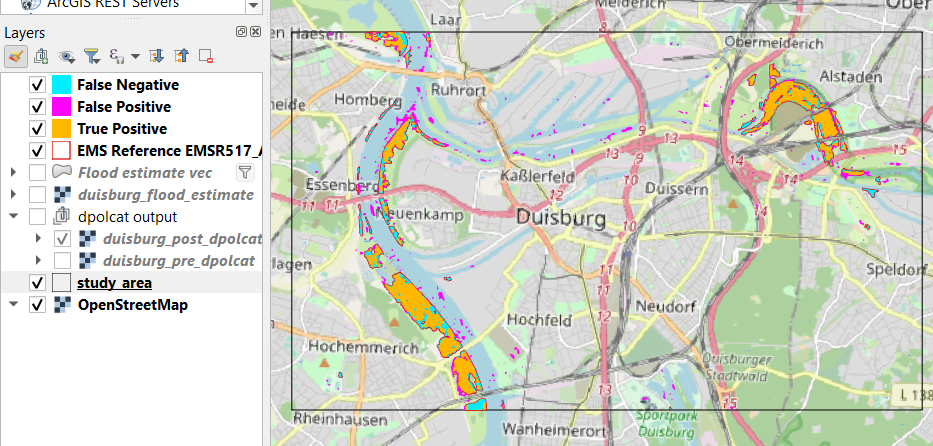

This results in the following area measurements:

| Quantity | Area |
| --- | --- |
True Positive | 2424521 |
False Positive | 564020 |
False Negative | 620833 |

Using these, an accuracy calculation can be made. Due to the sparse occurence of flooded areas in the study area, the [F1 score](https://www.v7labs.com/blog/f1-score-guide) is a more appropriate measure than overall accuracy in this case.

In [21]:
tp = 2424521
fp = 564020
fn = 620833

f1 = tp / (tp + 0.5 * (fp + fn))
f1

0.8036338053612136

So, our model yields an approximate accuracy (F1) of 80%.

## References

[1]: *GEO-CEOS stage 4 validation of the Satellite Image Automatic Mapper lightweight computer program for ESA Earth observation level 2 product generation - Part 1: Theory* (Andrea Baraldi, Michael Laurence Humber, Dirk Tiede & Stefan Lang) | Louis-Noel Moresi (Reviewing Editor) (2018), Cogent Geoscience, 4:1, DOI: [10.1080/23312041.2018.1467357](https://doi.org/10.1080/23312041.2018.1467357)

[2]: *Accessing Sentinel-1 RTC data with the Planetary Computer STAC API* (Jupyter Notebook, Microsoft Planetary Computer, accessed June 2023) ([link](https://pccompute.westeurope.cloudapp.azure.com/compute/hub/user-redirect/lab/tree/PlanetaryComputerExamples/datasets/sentinel-1-rtc/sentinel-1-rtc-example.ipynb))

[3]: *A Burned Area Extracting Method Using Polarization and Texture Feature of Sentinel-1A Images* (Shama et al, IEEE Geoscience and Remote Sensing Letters (Volume 20), Feb 2023, https://doi.org/10.1109/LGRS.2023.3246117)